In [1]:
from sklearn.model_selection import train_test_split
import numpy as np
import boto3
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import io

class S3ImageGenerator(Sequence):
    def __init__(self, bucket, prefix, batch_size=32, target_size=(224, 224), class_mode='binary', subset='training', split_ratio=0.9):
        self.s3 = boto3.client('s3')
        self.bucket = bucket
        self.prefix = prefix
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode
        self.subset = subset
        all_keys, all_labels = self._gather_keys_labels()
        
        # Splitting the data
        keys_train, keys_val, labels_train, labels_val = train_test_split(
            all_keys, all_labels, test_size=(1 - split_ratio), random_state=42)
        
        if self.subset == 'training':
            self.image_paths = keys_train
            self.labels = labels_train
        elif self.subset == 'validation':
            self.image_paths = keys_val
            self.labels = labels_val

    def _gather_keys_labels(self):
        keys = []
        labels = []
        paginator = self.s3.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=self.bucket, Prefix=self.prefix)
        for page in pages:
            for obj in page['Contents']:
                key = obj['Key']
                if key.endswith('.jpg') or key.endswith('.png'):  # Ensure it's an image file
                    keys.append(key)
                    parts = key.split('/')
                    if 'noncovid' in parts:
                        label = 0
                    elif 'covid' in parts:
                        label = 1
                    labels.append(label)
        return keys, labels

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        return np.array([
            self._load_image(path) for path in batch_x]), np.array(batch_y)


    def _load_image(self, path):
        try:
            # Fetch image from S3
            response = self.s3.get_object(Bucket=self.bucket, Key=path)
            image_content = response['Body'].read()
        
            # Open image using PIL
            image = Image.open(io.BytesIO(image_content))
        
            # Convert to RGB if not already in RGB mode
            if image.mode != 'RGB':
                image = image.convert('RGB')
        
            # Resize image
            image = image.resize(self.target_size)
        
            # Convert to numpy array and normalize
            image = np.array(image) / 255.0
        
            return image
        except Exception as e:
            print(f"Error loading or processing image {path}: {e}")
            # Return a blank image of the target size with RGB channels
            return np.zeros((self.target_size[0], self.target_size[1], 3))

bucket = 'covid19-ct-scan-proj'
prefix = 'train' 
# Create training and validation generators
train_generator = S3ImageGenerator(bucket, prefix, subset='training', split_ratio=0.9)
validation_generator = S3ImageGenerator(bucket, prefix, subset='validation', split_ratio=0.9)

2024-08-06 14:12:27.756347: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-06 14:12:56.250148: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-06 14:13:09.954902: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
labels = validation_generator.labels
print(np.unique(labels))

[0 1]


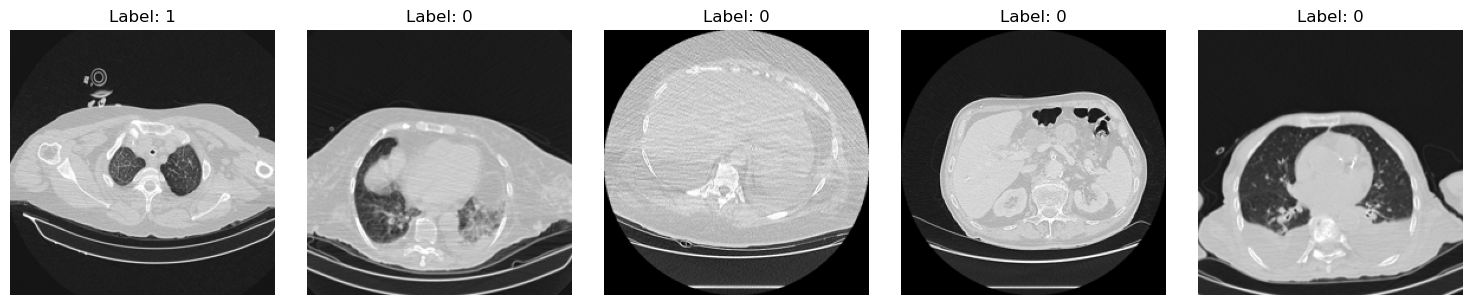

In [3]:
import matplotlib.pyplot as plt
images, labels = train_generator[0]

def plot_images(images, labels, nrows=1, ncols=5):
    """Plot a grid of images with labels."""
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 3 * nrows))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            # Display image
            ax.imshow(images[i])
            # Title with the class label
            ax.set_title(f'Label: {labels[i]}')
            ax.axis('off')
        else:
            ax.axis('off')  # Hide empty subplots
    plt.tight_layout()
    plt.show()

plot_images(images, labels, nrows=1, ncols=5)

In [4]:
from sklearn.model_selection import train_test_split
import numpy as np
import boto3
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from PIL import Image
import io
import matplotlib.pyplot as plt

# Define DenseNet121 model with Dropout
def create_densenet121_model(input_shape=(224, 224, 3), num_classes=1, dropout_rate=0.5):
    base_model = DenseNet121(include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)  # Add Dropout layer
    x = Dense(512, activation='relu')(x)
    x = Dropout(dropout_rate)(x)  # Add another Dropout layer
    predictions = Dense(num_classes, activation='sigmoid')(x)  # For binary classification, use sigmoid
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Freeze the convolutional base
    for layer in base_model.layers:
        layer.trainable = False
    
    return model

model = create_densenet121_model()

# Print model summary to see dropout layers and rates
#model.summary()

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint('densenet121_best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, mode='max')


2024-08-06 14:14:17.409722: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-06 14:14:28.343179: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-08-06 14:14:28.347190: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=15,
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/15


2024-08-06 14:15:18.375211: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1722953743.930404   13087 service.cc:145] XLA service 0x7ff7441448f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722953743.930441   13087 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-08-06 14:15:44.329773: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1722953744.720355   13087 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2987/2987 [==============================] - ETA: 0s - loss: 0.5989 - accuracy: 0.6912

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2987/2987 [==============================] - 7563s 3s/step - loss: 0.5989 - accuracy: 0.6912 - val_loss: 0.5261 - val_accuracy: 0.7733
Epoch 2/15
2987/2987 [==============================] - 7499s 3s/step - loss: 0.5375 - accuracy: 0.7284 - val_loss: 0.4923 - val_accuracy: 0.7853
Epoch 3/15
2987/2987 [==============================] - 7419s 2s/step - loss: 0.5186 - accuracy: 0.7407 - val_loss: 0.4736 - val_accuracy: 0.8208
Epoch 4/15
2987/2987 [==============================] - 7472s 3s/step - loss: 0.5017 - accuracy: 0.7538 - val_loss: 0.4506 - val_accuracy: 0.8319
Epoch 5/15
2987/2987 [==============================] - 6598s 2s/step - loss: 0.4901 - accuracy: 0.7605 - val_loss: 0.4503 - val_accuracy: 0.8438
Epoch 6/15
2987/2987 [==============================] - 6164s 2s/step - loss: 0.4753 - accuracy: 0.7699 - val_loss: 0.4342 - val_accuracy: 0.8630
Epoch 7/15
2987/2987 [==============================] - 6198s 2s/step - loss: 0.4643 - accuracy: 0.7791 - val_loss: 0.4077 - val_accura

332/332 [==============================] - 728s 2s/step - loss: 0.3168 - accuracy: 0.9124
Validation Loss: 0.3167547583580017
Validation Accuracy: 0.9124128818511963


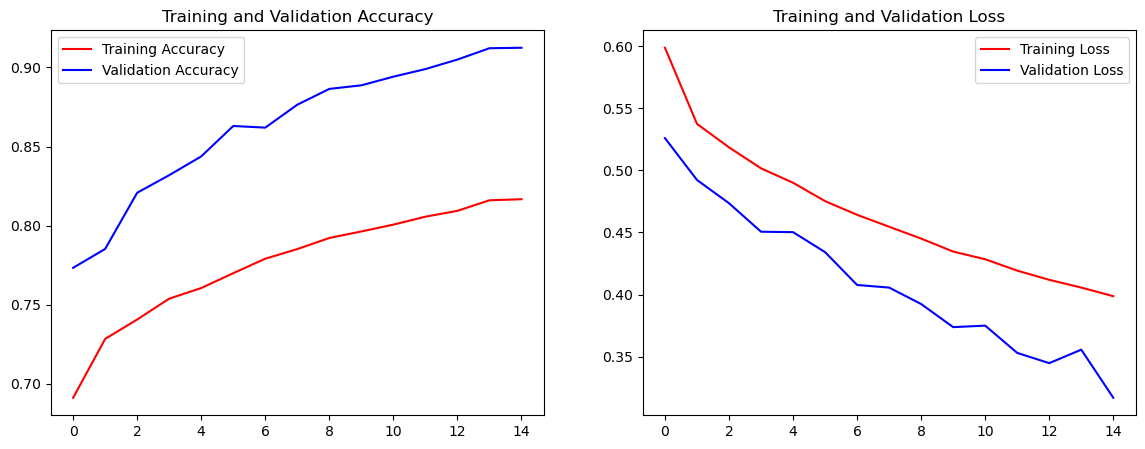

332/332 [==============================] - 769s 2s/step
Precision: 0.8877833958571195
Recall: 0.9574318381706245
F1 Score: 0.9212931618144888


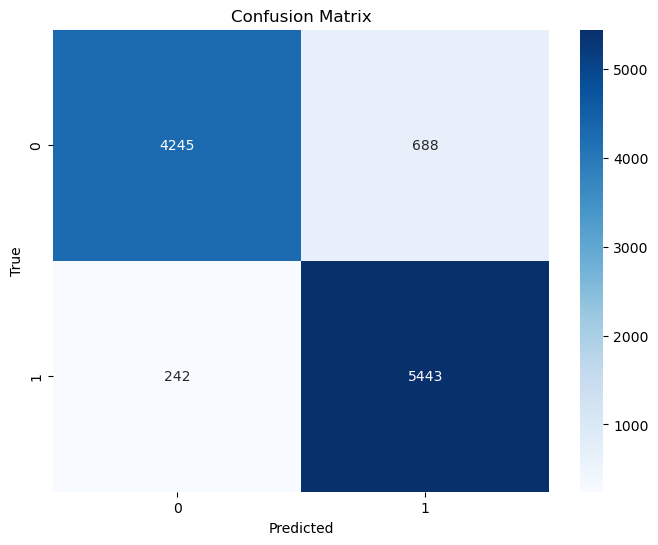

In [11]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Evaluate the model
results = model.evaluate(validation_generator)
print(f'Validation Loss: {results[0]}')
print(f'Validation Accuracy: {results[1]}')

# Plot training history
def plot_training_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_training_history(history)

# Load the best model
best_model = create_densenet121_model()
best_model.load_weights('densenet121_best_model.h5')

# Make predictions on the validation set
predictions = best_model.predict(validation_generator)
predicted_classes = np.round(predictions)

# Get true labels
true_classes = validation_generator.labels

# Calculate precision, recall, and f1 score
precision = precision_score(true_classes, predicted_classes)
recall = recall_score(true_classes, predicted_classes)
f1 = f1_score(true_classes, predicted_classes)

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Calculate and plot confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [20]:
from sklearn.model_selection import train_test_split
import numpy as np
import boto3
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image, UnidentifiedImageError
import io
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.layers import Input

class S3ImageGenerator(Sequence):
    def __init__(self, bucket, prefix, split=True, batch_size=32, target_size=(224, 224), class_mode='binary', subset='training', split_ratio=0.9):
        self.s3 = boto3.client('s3')
        self.bucket = bucket
        self.prefix = prefix
        self.split = split
        self.batch_size = batch_size
        self.target_size = target_size
        self.class_mode = class_mode
        self.subset = subset
        all_keys, all_labels = self._gather_keys_labels()
        self.index = 0
        # Splitting the data
        if split:
            keys_train, keys_val, labels_train, labels_val = train_test_split(
                all_keys, all_labels, test_size=(1 - split_ratio), random_state=42)

            if self.subset == 'training':
                self.image_paths = keys_train
                self.labels = labels_train
            elif self.subset == 'validation':
                self.image_paths = keys_val
                self.labels = labels_val
        else:
            self.image_paths = all_keys
            self.labels = all_labels

    def _gather_keys_labels(self):
        keys = []
        labels = []
        paginator = self.s3.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=self.bucket, Prefix=self.prefix)
        for page in pages:
            for obj in page['Contents']:
                key = obj['Key']
                if key.endswith('.jpg'):  # Ensure it's an image file
                    keys.append(key)
                    parts = key.split('/')
                    if 'noncovid' in parts:
                        label = 0
                    elif 'covid' in parts:
                        label = 1
                    labels.append(label)
        return keys, labels

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]
        
        images = []
        for path in batch_x:
            image = self._load_image(path)
            if image is not None:
                images.append(image)
            else:
                images.append(np.zeros((self.target_size[0], self.target_size[1], 3)))  # Handle unreadable images
        return np.array(images), np.array(batch_y)

    def __iter__(self):
        return self

    def __next__(self):
        if self.index < len(self):
            result = self[self.index]
            self.index += 1
            return result
        else:
            self.index = 0
            raise StopIteration
            
    def _load_image(self, path):
        try:
            # Fetch image from S3
            response = self.s3.get_object(Bucket=self.bucket, Key=path)
            image_content = response['Body'].read()
        
            # Open image using PIL
            image = Image.open(io.BytesIO(image_content))
        
            # Convert to RGB if not already in RGB mode
            if image.mode != 'RGB':
                image = image.convert('RGB')
        
            # Resize image
            image = image.resize(self.target_size)
        
            # Convert to numpy array and normalize
            image = np.array(image) / 255.0
        
            return image
        except Exception as e:
            print(f"Error loading or processing image {path}: {e}")
            # Return a blank image of the target size with RGB channels
            return np.zeros((self.target_size[0], self.target_size[1], 3))


bucket = 'covid19-ct-scan-proj'
prefix = 'validation' 
test_generator = S3ImageGenerator(bucket, prefix, split=False, subset='validation', split_ratio=0.9)


In [22]:
# Use the sliced generator to predict
predictions = model.predict(test_generator)
# Convert probabilities to binary labels (assuming binary classification)
predicted_labels = (predictions > 0.5).astype(int)

2361/2361 [==============================] - 5306s 2s/step


F1 Score: 0.7143372329529882
Accuracy: 0.7378197320341048
Precision: 0.7217185997026846
Recall: 0.7071053232807859


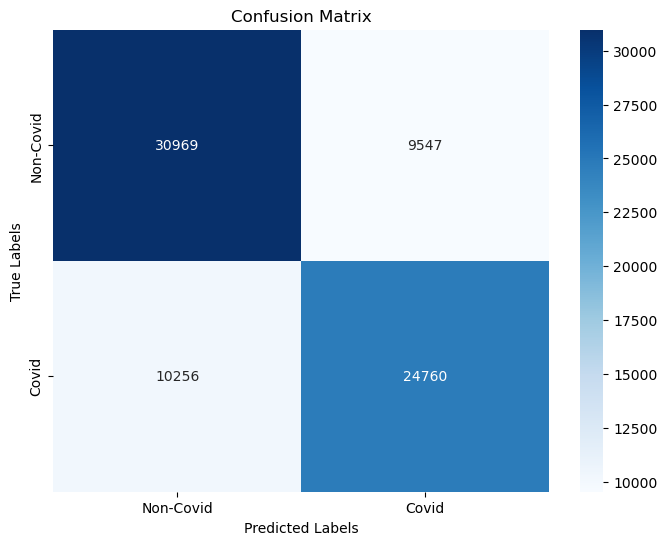

In [24]:
true_labels = test_generator.labels
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)
print("F1 Score:", f1)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print("Accuracy:", accuracy)

# Calculate precision
precision = precision_score(true_labels, predicted_labels)
print("Precision:", precision)

# Calculate recall
recall = recall_score(true_labels, predicted_labels)
print("Recall:", recall)

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plotting the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Covid', 'Covid'], yticklabels=['Non-Covid', 'Covid'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
